# EDA - MIDI files and artists representation

In [ ]:
import os
import pretty_midi
import midi_access as midi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


sns.set_theme(style="whitegrid")


In [ ]:

# Example usage:
base_midi_dir = './dataset/NN_midi_files_extended/'  # Update with your MIDI folder path


In [ ]:
train_dir = os.path.join(base_midi_dir, 'train')
test_dir = os.path.join(base_midi_dir, 'test')
dev_dir = os.path.join(base_midi_dir, 'dev')


artist_midi_train_dict = midi.load_midi_files_by_artist(train_dir)
artist_midi_test_dict = midi.load_midi_files_by_artist(test_dir)
artist_midi_dev_dict = midi.load_midi_files_by_artist(dev_dir)

artist_midi_dict = {**artist_midi_train_dict, **artist_midi_test_dict, **artist_midi_dev_dict}
artist_classes = list(artist_midi_dict.keys())
# Now artist_midi_dict maps each artist to a list of their MIDI data


/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


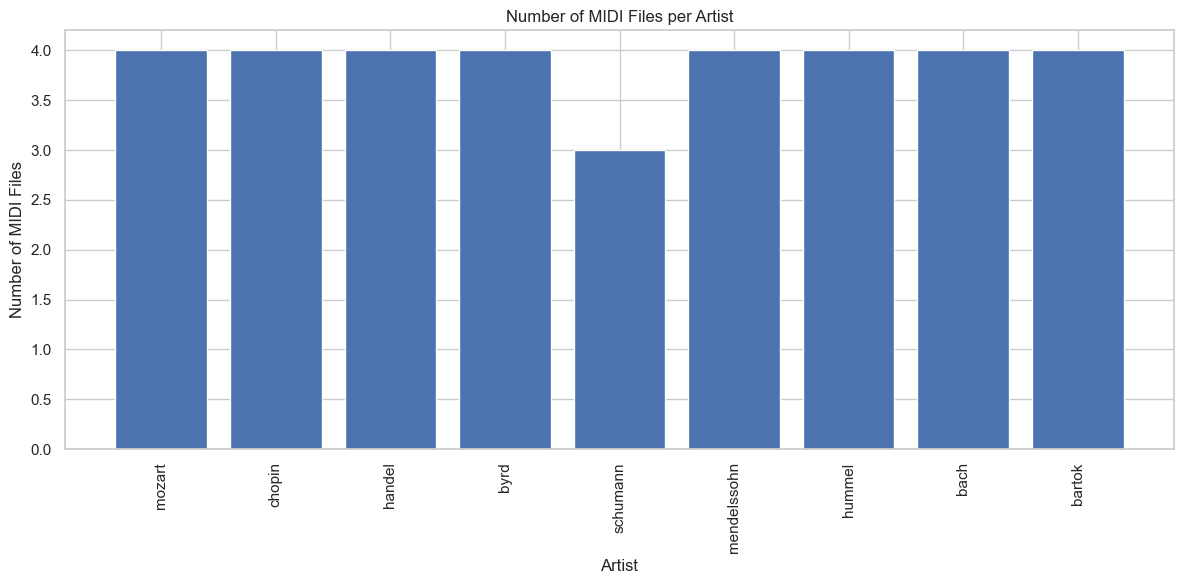

In [45]:
import matplotlib.pyplot as plt

# Count number of MIDI files per artist
artist_counts = {artist: len(midi_list) for artist, midi_list in artist_midi_dict.items()}

# Bar chart of MIDI files per artist
plt.figure(figsize=(12, 6))
plt.bar(artist_counts.keys(), artist_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of MIDI Files')
plt.title('Number of MIDI Files per Artist')
plt.tight_layout()
plt.show()

# Artist feature examples

we can use these features in order to create a classification

In [ ]:
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

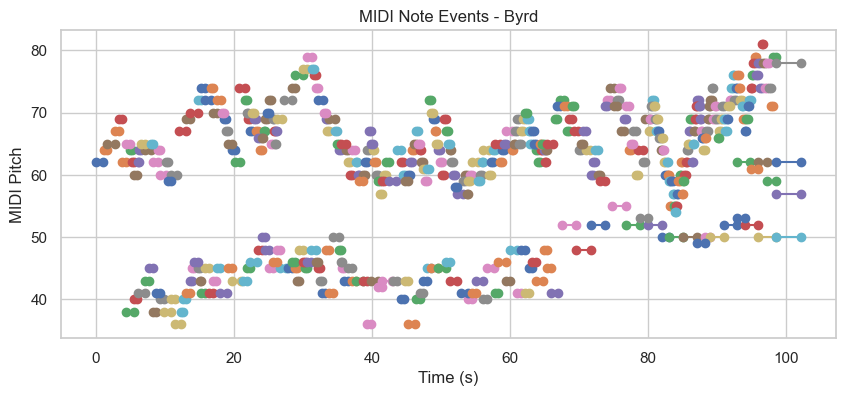

In [47]:

midi_data = artist_midi_dict['byrd'][0]  



# Visualize the MIDI data
def visualize_midi(midi_data):
    plt.figure(figsize=(10, 4))
    plt.title('MIDI Note Events - Byrd')
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            plt.plot([note.start, note.end], [note.pitch, note.pitch], marker='o')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.show()

visualize_midi(midi_data)

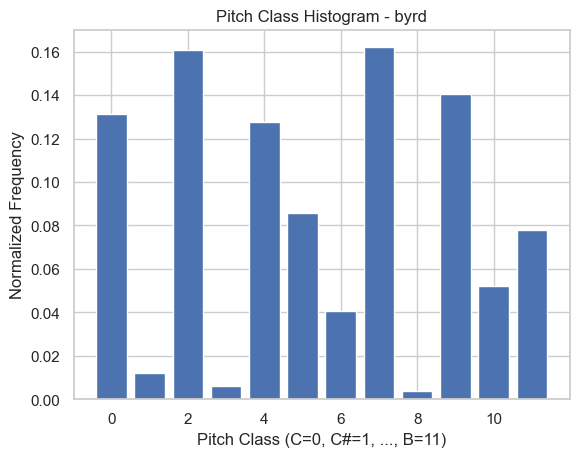

In [ ]:
import numpy as np

# Aggregate for all MIDI files of an artist
artist = 'byrd'
pitch_class_hist = np.zeros(12)
for midi in artist_midi_dict[artist]:
    pitch_class_hist += midi.get_pitch_class_histogram(midi)
pitch_class_hist /= len(artist_midi_dict[artist])

plt.bar(range(12), pitch_class_hist)
plt.xlabel('Pitch Class (C=0, C#=1, ..., B=11)')
plt.ylabel('Normalized Frequency')
plt.title(f'Pitch Class Histogram - {artist}')
plt.show()

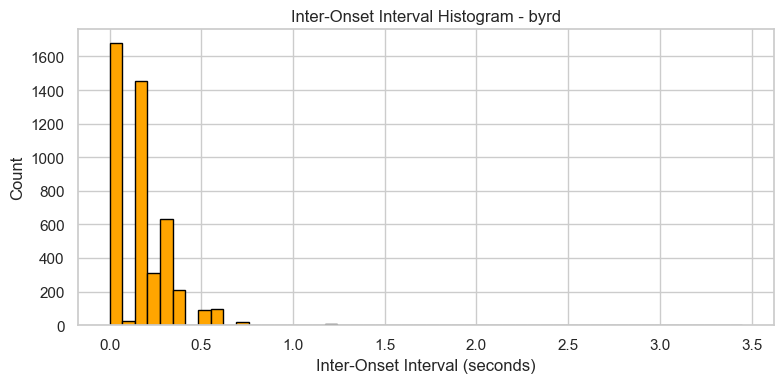

In [49]:


def get_inter_onset_intervals(midi_data):
    # Collect all note start times
    onsets = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            onsets.append(note.start)
    onsets = np.sort(onsets)
    # Compute differences between consecutive onsets
    iois = np.diff(onsets)
    return iois

artist = 'byrd'
all_iois = []
for midi in artist_midi_dict[artist]:
    iois = get_inter_onset_intervals(midi)
    all_iois.extend(iois)

plt.figure(figsize=(8, 4))
plt.hist(all_iois, bins=50, color='orange', edgecolor='black')
plt.xlabel('Inter-Onset Interval (seconds)')
plt.ylabel('Count')
plt.title(f'Inter-Onset Interval Histogram - {artist}')
plt.tight_layout()
plt.show()

Chord (0, 4): 71 times
Chord (0, 9): 60 times
Chord (0, 4, 7): 57 times
Chord (4, 7): 54 times
Chord (2, 7, 11): 50 times
Chord (7, 11): 46 times
Chord (5, 9): 42 times
Chord (2, 5): 39 times
Chord (2, 6): 35 times
Chord (2, 11): 33 times
Chord (2, 9): 30 times
Chord (2, 7): 30 times
Chord (2, 5, 10): 30 times
Chord (0, 5, 9): 24 times
Chord (2, 5, 9): 23 times


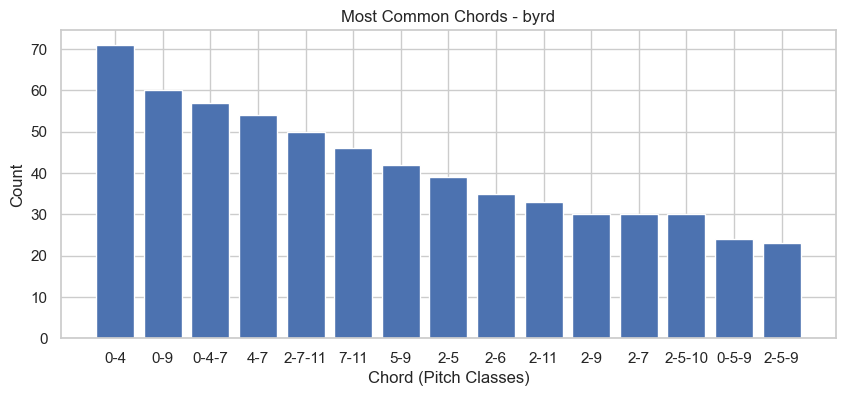

In [ ]:


artist = 'byrd'
chord_counter = Counter()
for midi in artist_midi_dict[artist]:
    chords = midi.extract_chords(midi)
    chord_counter.update(chords)

# Show the most common chords (as pitch class sets)
most_common_chords = chord_counter.most_common(15)
for chord, count in most_common_chords:
    print(f"Chord {chord}: {count} times")

# Optional: Bar plot of top chords
labels = ['-'.join(map(str, chord)) for chord, _ in most_common_chords]
counts = [count for _, count in most_common_chords]
plt.figure(figsize=(10, 4))
plt.bar(labels, counts)
plt.xlabel('Chord (Pitch Classes)')
plt.ylabel('Count')
plt.title(f'Most Common Chords - {artist}')
plt.show()

## Create a Features Tensor

In [ ]:

# Aggregate features for an artist
def get_artist_feature_tensor(midi_list, top_chords):
    pitch_hist = np.zeros(12)
    ioi_hist = np.zeros(20)
    chord_hist = np.zeros(len(top_chords))
    for midi in midi_list:
        pitch_hist += midi.get_pitch_class_histogram(midi)
        ioi_hist += midi.get_ioi_histogram(midi)
        chord_hist += midi.get_chord_histogram(midi, top_chords)
    n = len(midi_list)
    feature_vector = np.concatenate([pitch_hist/n, ioi_hist/n, chord_hist/n])
    return feature_vector

# Example: get tensor for 'byrd'
artist = 'byrd'
feature_tensor = get_artist_feature_tensor(artist_midi_dict[artist], top_chords)
print("Feature tensor shape:", feature_tensor.shape)
print("Feature tensor:", feature_tensor)

Feature tensor shape: (52,)
Feature tensor: [0.13108093 0.0119175  0.16083758 0.00590551 0.12743497 0.08572096
 0.04071185 0.16204698 0.00386235 0.14040074 0.05211105 0.07796958
 3.45793405 2.64427449 2.44123959 0.68462882 0.01460236 0.63862416
 0.01216545 0.06850731 0.00953347 0.         0.01666995 0.01182033
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10958232 0.06376552 0.10194385 0.07253993
 0.03195597 0.01799001 0.02538897 0.12237385 0.07655911 0.05277107
 0.02774628 0.01483505 0.01088029 0.06655077 0.01799001 0.00524405
 0.01418373 0.0641787  0.06735836 0.03616215]
